# EDA of Data Labels & Dataset Curation

Now that we have a first pass of our annotations, it is worth spending time looking at and understanding the variations in our annotations. This will support our goals in a few ways: by enabling us to better understand the variation of the underlying dataset for a particular field and additinally better understand behavior of the models we will build, where they are doing well, and where they are failing to perform adequately.

This notebook will look at the characteristics and distribution of 3 populations:
- The corpus
- The semantic search annotations
- The random sample annotations

We will first go through the payment terms annotations, and the exercises will have the user also assess the limitation of liability annotations.

In [11]:
import pandas as pd
import glob
import spacy
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
import annoy
from annoy import AnnoyIndex
import umap.umap_ as umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter
import string
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from dotenv import load_dotenv

### if you do not already have the nltk packages below, uncomment and run once to download (then re-comment)
# nltk.download('punkt_tab')

In [3]:
sent_emb_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

load_dotenv()
HOME_DIRECTORY = os.getenv("HOME_DIRECTORY")

<br/>

Below we will read in the embeddings we saved previously to save time and compute.

*Note*: If you do not have enough space on your computer to load the embeddings in memory, we recommend running this in a cloud instance or reducing the size of the corpus to meet the specs of your specific machine setup.

In [4]:
sentence_embeddings = pd.read_pickle(os.path.join(HOME_DIRECTORY, 'data', 
                                                  'data_pickles', 'corpus_sentences_embedded.pkl'))

<br/>

First, let's set up some basic preprocessing functions to support our qualitative EDA of the annotations.

In [5]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_text = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return filtered_text

def generate_ngrams(text, n):
    words = remove_stopwords(text)
    n_grams = ngrams(words, n)
    return [' '.join(gram) for gram in n_grams]

def ngram_frequencies(text_array, n):
    ngram_freq = Counter()
    for text in text_array:
        ngrams_list = generate_ngrams(text, n)
        ngram_freq.update(ngrams_list)
    # Create DataFrame from n-gram frequencies
    df = pd.DataFrame(list(ngram_freq.items()), columns=[str(n)+'-gram', str(n)+' Frequency'])
    df = df.sort_values(by=str(n)+' Frequency', ascending=False).reset_index(drop=True)
    return df

def get_top_features_tfidf(corpus, ntop):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(corpus)
    importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
    tfidf_features = np.array(tfidf_vectorizer.get_feature_names_out())
    return pd.DataFrame((importance, tfidf_features[importance])).T[:ntop]

def plot_nn_interactive(sentence_embeddings, embedding_col, sent_col, sample_size=None):
    if sample_size is None:
        sentence_embeddings_sample = sentence_embeddings
    else:
        sentence_embeddings_sample = sentence_embeddings.sample(sample_size, random_state=10935)
    
    reducer = umap.UMAP(n_neighbors=20, random_state=1)
    umap_embeds = reducer.fit_transform(np.array([np.array(x) for x in sentence_embeddings_sample[embedding_col].values]))
    
    df_explore = pd.DataFrame(
        data = {
            'text': sentence_embeddings_sample[sent_col].values
        }
    )
    
    df_explore['x'] = umap_embeds[:,0]
    df_explore['y'] = umap_embeds[:,1]
    
    chart = alt.Chart(df_explore).mark_circle(size=60).encode(
        x = alt.X(
            'x',
            scale=alt.Scale(zero=False)
        ),
        y = alt.Y(
            'y',
            scale=alt.Scale(zero=False)
        ),
        tooltip=['text'],
    ).properties(
        title="Nearest Neighbors",
        width=700,
        height=400)
    
    return chart.interactive()

def plot_comparison_embd_space(sentence_embeddings, embedding_col, sample_index, sample_size=None):
    if sample_size is None:
        sentence_embeddings_sample = sentence_embeddings
    else:
        sentence_embeddings_sample = sentence_embeddings.sample(sample_size, random_state=100)
        sentence_embeddings_sample = pd.concat((sentence_embeddings_sample, 
                                                sentence_embeddings[sentence_embeddings.index.isin(sample_index)]))

    reducer = umap.UMAP(n_neighbors=20, random_state=1)
    umap_embeds = reducer.fit_transform(np.array([np.array(x) for x in sentence_embeddings_sample[embedding_col].values]))
    plt.scatter(umap_embeds[:,0], umap_embeds[:,1], alpha=0.2, color='royalblue', s=3)
    
    # sentence_embeddings[sentence_embeddings['sentence_index'].isin(sample_index)]
    plt.scatter(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index)], 
                umap_embeds[:,1][sentence_embeddings_sample.index.isin(sample_index)],
                alpha=0.8, color='plum', s=5)
    plt.xlabel('Umap Dimension 1'); plt.ylabel('Umap Dimension 2')
    return

<br/><br/>

## Annotation EDA: Payment Terms

First, let's look at the payment terms annotations and do some basic exploratory analysis on our annotated samples.

In [6]:
payment_annos_all = pd.read_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_semantic_search-annotated.xlsx'), engine='openpyxl')
payment_annos_all['Embedding'] = payment_annos_all['Text'].apply(lambda t: sent_emb_model.encode(t))
payment_annos = payment_annos_all[payment_annos_all['Answer']!='FALSE POSITIVE']
payment_annos[['Filename', 'Text', 'Answer']].head()

,Filename,Text,Answer
0,tm2421105d1_ex10-1.htm,Payment of invoices submitted for Services wil...,30
1,tm2022502d7_ex10-1.htm,Except as the applicable Provider and Recipien...,30
2,d203747dex1015.html,6.3 Unless otherwise agreed in writing by\nthe...,30
3,pinstripesdistributionag.html,The Customer agrees to pay such invoices withi...,30
4,spar ex99-1.htm,● All\n ...,30


<br/>

Looking at the annotations visually in embedding space helps us to confirm that we haven't over-represented one particular manifestation of the language we're looking for. We want our training data to be well-balanced so that our models (or prompts) don't overfit to a particular variation in the dataset, even if it is highly frequent.

In the plot below, we will be looking for validation that our annotations are varied. If we see tight clusters with many annotations, that is an indication that we may have over-represented a particular example. In these cases, it's worth investigating the annotations in that cluster to verify.

In [7]:
plot_nn_interactive(payment_annos, 'Embedding', 'Text')

/Users/rachelwagner-kaiser/.pyenv/versions/tc2r_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


alt.Chart(...)

<br/>

Next, we can look more qualitatively at some of the common language patterns we see in our annotations - first, let's look at the top TF-IDF n-grams:

In [12]:
n = 100
gram1 = ngram_frequencies(payment_annos['Text'], 1).head(n)
gram2 = ngram_frequencies(payment_annos['Text'], 2).head(n)
gram3 = ngram_frequencies(payment_annos['Text'], 3).head(n)

liab_top_freq = pd.concat([gram1, gram2, gram3], ignore_index=True, axis=1)
liab_top_freq.columns = ['1-gram', '1 Frequency', '2-gram', '2 Frequency', '3-gram', '3 Frequency']

liab_top_freq.head(15)

,1-gram,1 Frequency,2-gram,2 Frequency,3-gram,3 Frequency
0,days,291,within days,124,process payment within,74
1,within,251,days receipt,110,city process payment,61
2,invoice,232,payment within,82,within days receipt,59
3,receipt,189,process payment,77,payment within days,57
4,payment,174,thirty days,66,supporting documentation necessary,53
5,city,141,receipt invoice,66,within thirty days,52
6,shall,132,city process,66,invoices supporting documentation,43
7,invoices,95,within thirty,59,receipt invoices supporting,43
8,company,89,receipt invoices,56,days receipt invoices,42
9,pay,84,documentation necessary,55,services provided agreement,39


<br/>

We can also look at the "top features" that the TF-IDF calculation indicates may be most discriminatory when distinguishing this set of annotations.

In [13]:
top_tfidf = get_top_features_tfidf(payment_annos['Text'], ntop=50)
top_tfidf.head(15)

,0,1
0,123,city
1,314,invoice
2,172,days
3,414,payment
4,479,receipt
5,19,60
6,449,process
7,14,30
8,316,invoices
9,556,shall


<br/>

### Exercise 5.1:

It is good practice to think critically about the signals in our annotations and dataset.
- Which n-grams are surprising for the payment terms context?
- What do the "top importance" words from TF-IDF make sense to us as humans? Which do not?

<br/>

<br/>

### Exercise 5.2:

Repeat the activities above for limitation of liability annotations to look at the annotations in embedding space. Are the annotations spread out, similar to the payment terms annotations distribution? Are there any pockets of over-representation in the limitation of liability annotations?

<br/>

<br/>

### Exercise 5.3:

Repeat the activities above for limitation of liability annotations to look at top TF-IDF n-grams and features of top importance. Compare and contrast to the payment terms results:

- Which n-grams are surprising for the liability clause?
- What do the "top importance" words from TF-IDF make sense to us as humans? Which do not?

<br/>

<br/>
<br/>

### Annotation vs Corpus Variation

Below, we return visually to the concept that embeddings have strong discriminatory power in helping us retrieve relevant information from a document. In the below plot, we have reduced the embedding space from N dimensions to just 2 dimensions, but is still clear that the variation within our annotation sample is significantly less than the variation in the broader document content and corpus.

Again, this gives us a good feature set that can discriminate between what we are looking for (payment terms) across all the sentences in all the documents, but that discriminatory power is much reduced by leveraging embeddings to classify sentences within our payment terms annotation set.

Another way to think of this concept is that there is greater variability in the negative examples (non-payment-terms-related sentences) than our positive examples (our payment terms annotations). This concept - and variation imbalance - will be very important as we start our model development.

/Users/rachelwagner-kaiser/.pyenv/versions/tc2r_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


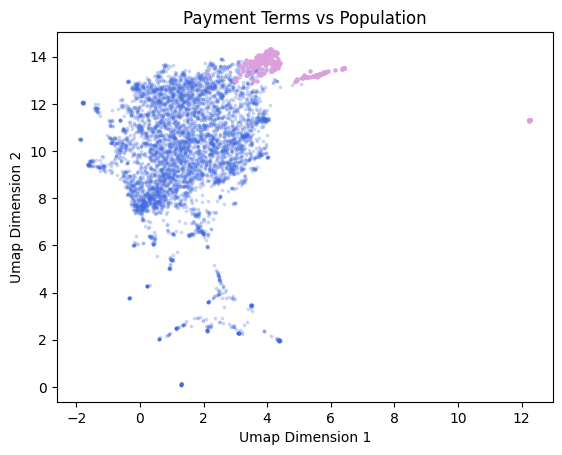

In [14]:
plot_comparison_embd_space(sentence_embeddings, 'Embedding', payment_annos['Index'], sample_size=5000)
plt.title('Payment Terms vs Population');

<br/><br/>

We can also look at the distribution in a 2-D format to compare the distribution of the annotations to the distribution of the entire corpus:

In [15]:
def plot_variability_hist(sentence_embeddings, embedding_col, sent_col, sample_index, sample_size=None, nbins=20):
    if sample_size is None:
        sentence_embeddings_sample = sentence_embeddings
    else:
        sentence_embeddings_sample = sentence_embeddings.sample(sample_size, random_state=100)
        sentence_embeddings_sample = pd.concat((sentence_embeddings_sample, 
                                                sentence_embeddings[sentence_embeddings.index.isin(sample_index)]))

    reducer = umap.UMAP(n_neighbors=20, random_state=10)
    umap_embeds = reducer.fit_transform(np.array([np.array(x) for x in sentence_embeddings_sample[embedding_col].values]))

    # Calculate histograms without plotting to get heights, with same bin ranges
    heights1, bins1 = np.histogram(umap_embeds[:,0], bins=nbins)
    heights2, bins2 = np.histogram(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index)], bins=bins1)

    # Plot histogram for Dataset 1, normalizing height to 1
    plt.bar(bins1[:-1], heights1 / np.max(heights1), alpha=0.9, color='royalblue', width=0.7, label='Corpus')
    # Plot histogram for Dataset 2, normalizing height to 1
    plt.bar(bins2[:-1], heights2 / np.max(heights2), alpha=0.9, color='plum', width=0.7, label='Annotations')

    plt.xlabel('UMap Dimension 1'); plt.ylabel('# Sentences (Normalized to Height of 1)')
    plt.legend()
    return

/Users/rachelwagner-kaiser/.pyenv/versions/tc2r_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


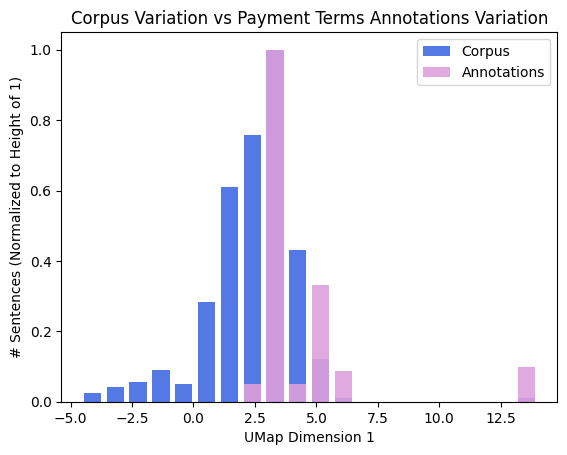

In [16]:
plot_variability_hist(sentence_embeddings, 'Embedding', 'sentence_text', payment_annos['Index'], sample_size=5000)
plt.title('Corpus Variation vs Payment Terms Annotations Variation');

<br/><br/>

### Exercise 5.4:

For UMap Dimension 2 for payment terms annotations, is the variation still significantly narrower for the annotations compared to the full corpus?

<br/>

<br/><br/>

### Exercise 5.5:

Create a 2-D plot of the limitation of liability annotations compared to the full corpus. Is the distribution similar to payment terms annotations vs the corpus? If so, what might be root causes?

<br/>

<br/><br/>

### Exercise 5.6:

Create a 1-D plot of the limitation of liability annotations compared to the full corpus. Is the distribution similar to payment terms annotations vs the corpus? Why might this be the case?

<br/>

<br/><br/><br/>

### Targeted vs Random Annotations

As we discuss in Chapter 8, we want to spend our time intelligently when identifying annotations. Remembering that our goal is to train a model with as much variation in language as we can find, we want our annotations to span the range of language we see in the population in order to develop the most generalizable model possible.

Let's compare our more targeted annotation approach with the approach of a random selection of documents below, looking at the first couple dimensions of our Umap reducer.

In [17]:
def plot_variability_hist_sample(sentence_embeddings, embedding_col, sent_col, sample_index1, sample_index2, sample_size=None, nbins=20):
    sentence_embeddings_sample = pd.concat((sentence_embeddings[sentence_embeddings.index.isin(sample_index1)], 
                                            sentence_embeddings[sentence_embeddings.index.isin(sample_index2)]))
    reducer = umap.UMAP(n_neighbors=20, random_state=10)
    umap_embeds = reducer.fit_transform(np.array([np.array(x) for x in sentence_embeddings_sample[embedding_col].values]))

    # Calculate histograms without plotting to get heights, with same bin ranges
    heights1, bins1 = np.histogram(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index1)], bins=nbins)
    heights2, bins2 = np.histogram(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index2)], bins=bins1)

    plt.bar(bins1[:-1], heights1, alpha=0.7, color='royalblue', width=0.2, label='Semantic Search')
    plt.bar(bins2[:-1], heights2, alpha=0.7, color='plum', width=0.2, label='Random')
    plt.xlabel('UMap Dimension 1'); plt.ylabel('# Sentences')
    plt.legend()

    print('Range of semantic search dimension 1:', 
          np.max(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index1)])-
          np.min(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index1)]))
    print('Range of random dimension 1:', 
          np.max(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index2)])-
          np.min(umap_embeds[:,0][sentence_embeddings_sample.index.isin(sample_index2)]))
    return

<br/><br/>

Let's now assess the annotated data that was randomly selected against the annotations from semantic search:

In [18]:
payment_annos_random = pd.read_excel(os.path.join(HOME_DIRECTORY, 'data', 'annotations', 'Payment_random_sample-annotated.xlsx'), 
                                  engine='openpyxl')
payment_annos_random['Embedding'] = payment_annos_random['Text'].apply(lambda t: sent_emb_model.encode(t))
payment_annos_random = payment_annos_random[payment_annos_random['Answer']!='FALSE POSITIVE']
payment_annos_random[['Filename', 'Text', 'Answer']].head()

,Filename,Text,Answer
0,d203747dex1015.html,6.3 Unless otherwise agreed in writing by\nthe...,30
1,pinstripesdistributionag.html,The Customer agrees to pay such invoices withi...,30
2,spar ex99-1.htm,● All\n ...,30
3,a20240630ex103consultingag.html,Payment terms: net 30 days from receipt of inv...,30
4,cbll-ex10_28.html,The Company will remit payment for properly su...,30


/Users/rachelwagner-kaiser/.pyenv/versions/tc2r_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Range of semantic search dimension 1: 16.780706
Range of random dimension 1: 4.6731095


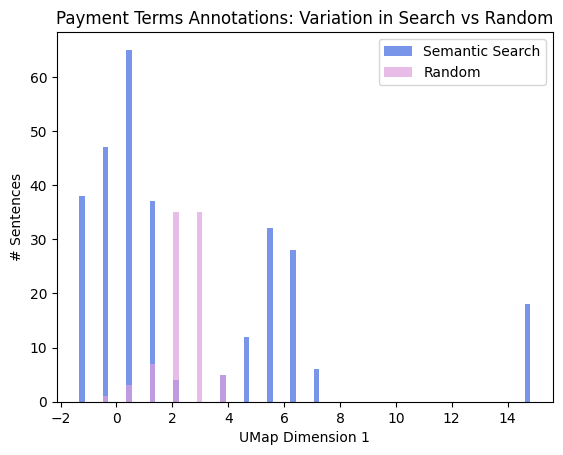

In [19]:
plot_variability_hist_sample(sentence_embeddings, 'Embedding', 'sentence_text', 
                             payment_annos['Index'], payment_annos_random['Index'], sample_size=5000)
plt.title('Payment Terms Annotations: Variation in Search vs Random');

<br/><br/>

Visually, we can see the range of random annotations being a bit narrower and the range of the targeted annotations (via semantic search) being wider. This is what we expect, given that we have targeted our annotations to focus explicitly on identifying variations in language. With a random sample, we could get extremely unlucky and end up with all of the documents in our random sample having the exact same language -- not ideal for training a generalizable model.


<br/><br/>

### Exercise 5.7:

Compare the range of variation in the semantic search annotations to that of the random annotations for the limitation of liability field. Are the ranges similar? Is this true for UMap Dimension 2 as well?

<br/>

<br/><br/>

### Exercise 5.8:

Continuing to assess the limitation of liability annotations, do the random annotations have a similar distribution in embeddings space to the semantic search annotations? Are there areas of potential over-representation?

*(Hint: Use the `plot_nn_interactive` function previously defined)*

<br/>